In [128]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge
from joblib import dump, load
from analysis.offsets import offsets
from scipy.stats import multivariate_normal

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/nullspace/")

%matplotlib inline

In [129]:
subjects = analysis.load_subjects()

In [130]:
mean_rewards = np.load("../subject_rewards.npy")

In [131]:
NUM_ENDPOINTS = 2
hit_ends = np.zeros(shape=(46,45,12,64))
hit_ends[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    target_counter = np.zeros(shape=(12),dtype=int)
    for session in list(subject.tasks["center_hold"].sorted_sessions()):
        for trial in session.sorted_trials():
            if trial.outcome == "Hit":
                hit_end = np.mean(trial.get_filtered_emg()[-NUM_ENDPOINTS:,:], axis=0)
                hit_ends[subject_idx,target_counter[trial.target_number-1],trial.target_number-1] = hit_end
                target_counter[trial.target_number-1] += 1
# this trial has an outlier, we just kill it
hit_ends[45,1,11,:] = np.nan
hit_end_means = np.nanmean(hit_ends, axis=(1))
hit_ends.shape, hit_end_means.shape

((46, 45, 12, 64), (46, 12, 64))

In [132]:
target_vecs = np.array([collection.compute_target_vec_from_number(i) for i in range(1,13)]).reshape(12,2)
target_stack = np.stack([target_vecs for _ in range(45)])

target_numbers = np.arange(1,13)
target_number_stack = np.stack([target_numbers for _ in range(45)])
target_stack.shape, target_number_stack.shape

((45, 12, 2), (45, 12))

In [133]:
def regress(X,y):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
    # X_train.shape, y_train.shape, X_test.shape, y_test.shape
    clf = LinearRegression().fit(X, y)
    cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
    scores = cross_val_score(clf, X, y, cv=cv)
    return scores.mean(), scores.std()

def ridge_regress(X,y):
    alphas = np.linspace(0,1,10,endpoint=True)
    alpha_score_means = []
    alpha_score_stds = []
    for alpha in alphas:
        clf = Ridge(alpha=alpha).fit(X, y)
        cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
        scores = cross_val_score(clf, X, y, cv=cv)
        alpha_score_means.append(scores.mean())
        alpha_score_stds.append(scores.std())
    max_idx = np.argmax(alpha_score_means)
    return alpha_score_means[max_idx], alpha_score_stds[max_idx], alphas[max_idx]
    # plt.plot(clf.coef_[0][list(range(56))+list(range(57,64))])
    # plt.plot(clf.coef_[1][list(range(56))+list(range(57,64))])
    # plt.plot(decoder[0],"k--")
    # plt.plot(decoder[1],"k--")

## regression of task and null

In [147]:
subject_score = []
subject_score_task = []
subject_score_null = []
subject_score_null_gaussian = []
for subject_idx in range(46):
    subject_hit_ends = hit_ends[subject_idx]
    X, idxs = analysis.remove_nan_rows(subject_hit_ends.reshape(-1,64),return_idx=True)
    y = target_stack.reshape(-1,2)[idxs]

    decoder = subjects[subject_idx].decoder[-2:,:]
    task, null = analysis.compute_subspaces(decoder)
    X_null = (null @ X.T).T
    X_task = (task @ X.T).T

    subject_score.append(regress(X,y)[0])
    subject_score_task.append(regress(X_task,y)[0])
    subject_score_null.append(regress(X_null,y)[0])
    X_null_gaussian = np.random.multivariate_normal(X_null.mean(axis=0),np.cov(X_null.T),size=X_null.shape[0])
    subject_score_null_gaussian.append(regress(X_null_gaussian,y)[0])

subject_score = np.array(subject_score)
subject_score_task = np.array(subject_score_task)
subject_score_null = np.array(subject_score_null)
subject_score_null_gaussian = np.array(subject_score_null_gaussian)

1.7152794162677976e-05


Text(0.5, 0, 'Mean Reward')

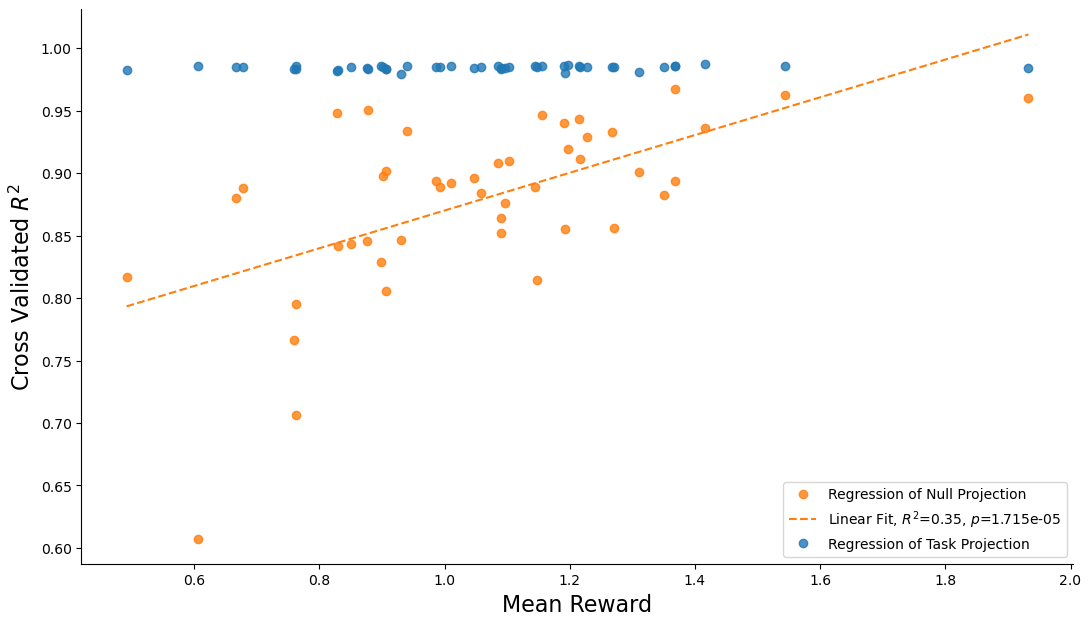

In [149]:
regression_fig = plt.figure()

# plt.plot(mean_rewards,(subject_score),"o",color="tab:red",alpha=0.8,label="Full")
# res = analysis.linear_fit(mean_rewards,(subject_score))
# x = analysis.linspace(mean_rewards)
# plot.plot_linear_fit(x,res,plt.gca(),color="tab:red",)
# print(res.pvalue)

plt.plot(mean_rewards,(subject_score_null),"o",color="tab:orange",alpha=0.8,label="Regression of Null Projection")
res = analysis.linear_fit(mean_rewards,(subject_score_null))
x = analysis.linspace(mean_rewards)
plot.plot_linear_fit(x,res,plt.gca(),color="tab:orange")
print(res.pvalue)

plt.plot(mean_rewards,(subject_score_task),"o",color="tab:blue",alpha=0.8,label="Regression of Task Projection")
# res = analysis.linear_fit(mean_rewards,(subject_score_task))
# x = analysis.linspace(mean_rewards)
# plot.plot_linear_fit(x,res,plt.gca(),color="tab:blue")
# print(res.pvalue)

# plt.plot(mean_rewards,(subject_score_null_gaussian),"o",color="tab:green",alpha=0.8,label="Regression of Gaussian with Null Statistics")

plt.legend()
plt.ylabel("Cross Validated $R^2$")
plt.xlabel("Mean Reward")

In [150]:
plot.save_figure(regression_fig,"regression_scores",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/regression_scores.pdf


The score is increasing, or the "error" of the regressor is decreasing, which implies that as performance increases, subjects' hits become more predictable, even in the nullspace!

## test with noise data

## try with logistic regression

In [137]:
# from sklearn.linear_model import LogisticRegression

# subject_hit_ends = hit_ends[subject_idx]
# X, idxs = analysis.remove_nan_rows(subject_hit_ends.reshape(-1,64),return_idx=True)
# y = target_stack.reshape(-1,2)[idxs]
# # print(X.shape, y.shape)
# decoder = subjects[subject_idx].decoder[-2:,:]
# task, null = analysis.compute_subspaces(decoder)
# X_null = (null @ X.T).T
# X_task = (task @ X.T).T

# clf = LogisticRegression(random_state=0,max_iter=1000,multi_class="multinomial").fit(X, y_numbers)
# cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
# scores = cross_val_score(clf, X, y_numbers, cv=cv)
# print(scores.mean(), scores.std())

# clf = LogisticRegression(random_state=0,max_iter=1000,multi_class="multinomial").fit(X_task, y_numbers)
# cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
# scores = cross_val_score(clf, X_task, y_numbers, cv=cv)
# print(scores.mean(), scores.std())

# clf = LogisticRegression(random_state=0,max_iter=1000,multi_class="multinomial").fit(X_null, y_numbers)
# cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
# scores = cross_val_score(clf, X_null, y_numbers, cv=cv)
# print(scores.mean(), scores.std())

In [138]:
# plt.figure()
# colors = ["ro","go","bo","mo","ko","r*","g*","b*","m*","k*","r^","g^"]
# for i, sample in enumerate(X_task):
#     n = y_numbers[i] - 1
#     plt.plot(X_task[i,0],X_task[i,1],colors[n])

In [139]:
# import matplotlib.colors as mcolors
# colors = list(mcolors.TABLEAU_COLORS.keys()) + ["k","m"]

In [140]:
# from sklearn.inspection import DecisionBoundaryDisplay
# import matplotlib.colors as mcolors
# from sklearn.datasets import make_classification

# # X, y = make_classification(n_samples=500,n_features=64,n_informative=12,n_redundant=52,n_classes=12,n_clusters_per_class=1)

# X_train, X_test, y_train, y_test = train_test_split(X,y_numbers,test_size=0.25)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# clf = LogisticRegression(max_iter=5000, random_state=2, multi_class="multinomial"
# ).fit(X_train, y_train)

# # print the training scores
# print("training score : %.3f (%s)" % (clf.score(X_test, y_test), "multinomial"))

# # _, ax = plt.subplots()
# # DecisionBoundaryDisplay.from_estimator(
# #     clf, X, response_method="auto", cmap=plt.cm.Paired, ax=ax
# # )
# # plt.title("Decision surface of LogisticRegression (%s)" % "multinomial")
# # plt.axis("tight")

# for i, color in zip(clf.classes_, colors):
#     idx = np.where(y_numbers == i)
#     plt.scatter(
#         X_task[idx, 0], X_task[idx, 1], c=color, edgecolor="black", s=20, zorder=100
#     )

# # Plot the three one-against-all classifiers
# xmin, xmax = plt.xlim()
# coef = clf.coef_ # @ decoder.T
# intercept = clf.intercept_ 

# def plot_hyperplane(c, color):
#     def line(x0):
#         return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

#     plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color)

# for i, color in zip(clf.classes_, colors):
#     plot_hyperplane(i-1, color)

# plt.ylim([-1,1])

### a linear classifier will struggle here! We could try to transform the data into a space that makes the clusters linearly separable, but let's just use a better tool

# try with nearest neighbors

In [151]:
from sklearn.metrics import brier_score_loss

def brier_multi(targets, probs):
    assert targets.shape == probs.shape, f"{targets.shape, probs.shape}"
    return np.mean(np.sum((probs - targets)**2, axis=1)) / 2

def true_classes_to_one_hot(true_classes,n_classes):
    assert np.max(true_classes) <= n_classes
    assert true_classes.shape[0] > true_classes.shape[1]
    one_hot_array = np.zeros(shape=(true_classes.shape[0],n_classes))
    for idx, class_number in enumerate(true_classes):
        one_hot_array[idx,class_number-1] = 1
    return one_hot_array

In [152]:
def probs_array(clf, true_classes, samples):
    probs = clf.predict_proba(samples)
    classes = clf.classes_
    output = np.zeros_like(true_classes)
    for i, c in enumerate(classes):
        output[:,c-1] = probs[:,i]
    return output

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [154]:
# X_train, X_test, y_train, y_test = train_test_split(X,y_numbers,test_size=0.5)
# clf = KNeighborsClassifier(n_neighbors=5)
# clf.set_params(weights="distance").fit(X_train, y_train)
# print(f"training score : {clf.score(X_test, y_test)}")
# predictions = clf.predict(X_test)
# cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
# disp.plot()
# true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
# probs = probs_array(clf, true_classes,X_test)
# print("Brier score error:", brier_multi(true_classes,probs))

# X_train, X_test, y_train, y_test = train_test_split(X_task,y_numbers,test_size=0.25)
# clf = KNeighborsClassifier(n_neighbors=5)
# clf.set_params(weights="distance").fit(X_train, y_train)
# print(f"training score : {clf.score(X_test, y_test)}")
# predictions = clf.predict(X_test)
# cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
# disp.plot()
# true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
# probs = probs_array(clf, true_classes,X_test)
# print("Brier score error:", brier_multi(true_classes,probs))

# X_train, X_test, y_train, y_test = train_test_split(X_null,y_numbers,test_size=0.25)
# clf = KNeighborsClassifier(n_neighbors=5)
# clf.set_params(weights="distance").fit(X_train, y_train)
# print(f"training score : {clf.score(X_test, y_test)}")
# predictions = clf.predict(X_test)
# cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
# disp.plot()
# true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
# probs = probs_array(clf, true_classes,X_test)
# print("Brier score error:", brier_multi(true_classes,probs))

In [155]:
scores_full = []
scores_task = []
scores_null = []
brier_score_full = []
brier_score_task = []
brier_score_null = []

scores_null_gaussian_matching = []
brier_score_null_gaussian_matching = []
scores_null_gaussian_white = []
brier_score_null_gaussian_white = []
scores_null_gaussian_normal = []
brier_score_null_gaussian_normal = []
scores_null_gaussian_cov = []
brier_score_null_gaussian_cov = []

for subject_idx in range(46):
    subject_hit_ends = hit_ends[subject_idx]
    X, idxs = analysis.remove_nan_rows(subject_hit_ends.reshape(-1,64),return_idx=True)
    y_numbers = target_number_stack.reshape(-1)[idxs]
    decoder = subjects[subject_idx].decoder[-2:,:]
    task, null = analysis.compute_subspaces(decoder)
    X_null = (null @ X.T).T
    X_task = (task @ X.T).T

    X_train, X_test, y_train, y_test = train_test_split(X,y_numbers,test_size=0.5)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.set_params(weights="distance").fit(X_train, y_train)
    scores_full.append(clf.score(X_test, y_test))
    true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
    probs = probs_array(clf, true_classes,X_test)
    brier_score_full.append(brier_multi(true_classes,probs))

    X_train, X_test, y_train, y_test = train_test_split(X_task,y_numbers,test_size=0.25)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.set_params(weights="distance").fit(X_train, y_train)
    scores_task.append(clf.score(X_test, y_test))          
    true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
    probs = probs_array(clf, true_classes,X_test)
    brier_score_task.append(brier_multi(true_classes,probs))

    X_train, X_test, y_train, y_test = train_test_split(X_null,y_numbers,test_size=0.25)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.set_params(weights="distance").fit(X_train, y_train)
    scores_null.append(clf.score(X_test, y_test))          
    true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
    probs = probs_array(clf, true_classes,X_test)
    brier_score_null.append(brier_multi(true_classes,probs))

    X_null_gaussian = np.random.multivariate_normal(X_null.mean(axis=0),np.cov(X_null.T),size=X_null.shape[0])
    X_train, X_test, y_train, y_test = train_test_split(X_null_gaussian,y_numbers,test_size=0.25)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.set_params(weights="distance").fit(X_train, y_train)
    true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
    probs = probs_array(clf, true_classes,X_test)
    scores_null_gaussian_matching.append(clf.score(X_test, y_test)) 
    brier_score_null_gaussian_matching.append(brier_multi(true_classes,probs))

    X_null_gaussian = np.random.multivariate_normal(X_null.mean(axis=0),np.eye(X_null.shape[1])*0.01,size=X_null.shape[0])
    X_train, X_test, y_train, y_test = train_test_split(X_null_gaussian,y_numbers,test_size=0.25)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.set_params(weights="distance").fit(X_train, y_train)
    true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
    probs = probs_array(clf, true_classes,X_test)
    scores_null_gaussian_white.append(clf.score(X_test, y_test)) 
    brier_score_null_gaussian_white.append(brier_multi(true_classes,probs))

    X_null_gaussian = np.random.multivariate_normal(np.zeros(shape=(X_null.shape[1])),np.eye(X_null.shape[1])*0.01,size=X_null.shape[0])
    X_train, X_test, y_train, y_test = train_test_split(X_null_gaussian,y_numbers,test_size=0.25)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.set_params(weights="distance").fit(X_train, y_train)
    true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
    probs = probs_array(clf, true_classes,X_test)
    scores_null_gaussian_normal.append(clf.score(X_test, y_test)) 
    brier_score_null_gaussian_normal.append(brier_multi(true_classes,probs))

    X_null_gaussian = np.random.multivariate_normal(np.zeros(shape=(X_null.shape[1])),np.cov(X_null.T),size=X_null.shape[0])
    X_train, X_test, y_train, y_test = train_test_split(X_null_gaussian,y_numbers,test_size=0.25)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.set_params(weights="distance").fit(X_train, y_train)
    true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
    probs = probs_array(clf, true_classes,X_test)
    scores_null_gaussian_cov.append(clf.score(X_test, y_test)) 
    brier_score_null_gaussian_cov.append(brier_multi(true_classes,probs))

(0.0, 1.1)

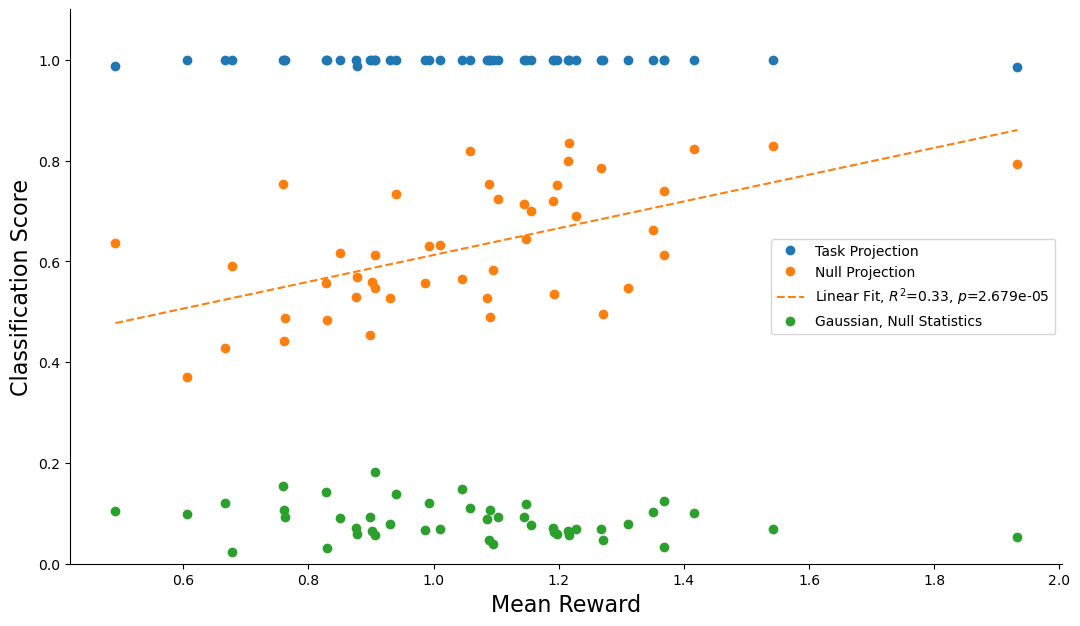

In [156]:
score_fig = plt.figure()
plt.plot(mean_rewards, scores_task,"o",label="Task Projection")
plt.plot(mean_rewards, scores_null,"o",color="tab:orange",label="Null Projection")
res = analysis.linear_fit(mean_rewards,scores_null)
x = analysis.linspace(mean_rewards)
plot.plot_linear_fit(x,res,plt.gca(),color="tab:orange")
plt.plot(mean_rewards, scores_null_gaussian_matching,"o",color="tab:green",label="Gaussian, Null Statistics")
# plt.plot(mean_rewards, scores_null_gaussian_white,"o",label="null mean")
# plt.plot(mean_rewards, scores_null_gaussian_cov,"o",label="null cov")
# plt.plot(mean_rewards, scores_null_gaussian_normal,"o",label="std normal")
plt.legend()
plt.ylabel("Classification Score")
plt.xlabel("Mean Reward")
plt.ylim([0,1.1])

# plt.figure()
# # plt.plot(mean_rewards,brier_score_full,"o",label="full")
# plt.plot(mean_rewards, brier_score_task,"o",label="task")
# plt.plot(mean_rewards, brier_score_null,"o",label="null")
# plt.plot(mean_rewards, brier_score_null_gaussian_matching,"o",label="null mean null cov")
# # plt.plot(mean_rewards, brier_score_null_gaussian_white,"o",label="null mean")
# # plt.plot(mean_rewards, brier_score_null_gaussian_cov,"o",label="null cov")
# # plt.plot(mean_rewards, brier_score_null_gaussian_normal,"o",label="std normal")
# plt.legend()

In [157]:
plot.save_figure(score_fig, "classification_scores",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/classification_scores.pdf


### we can predict performance from our ability to classify the null space activity. this means there is signal in the null space predictive of targets, AND the more predictive the null space is, the better subjects perform. This implies that higher performing subjects either purposefully attend to more than just the target space, or that their decoders allow them this advantage. 

## try with low and high variance PCA subsets 

In [48]:
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

colors = list(mcolors.TABLEAU_COLORS.keys()) + ["k","m"]
subject_idx = 29
subject_hit_ends = hit_ends[subject_idx]
X, idxs = analysis.remove_nan_rows(subject_hit_ends.reshape(-1,64),return_idx=True)
y_numbers = target_number_stack.reshape(-1)[idxs]
decoder = subjects[subject_idx].decoder[-2:,:]
task, null = analysis.compute_subspaces(decoder)
X_null = (null @ X.T).T
X_task = (task @ X.T).T

Text(0.5, 1.0, 'Null Projection')

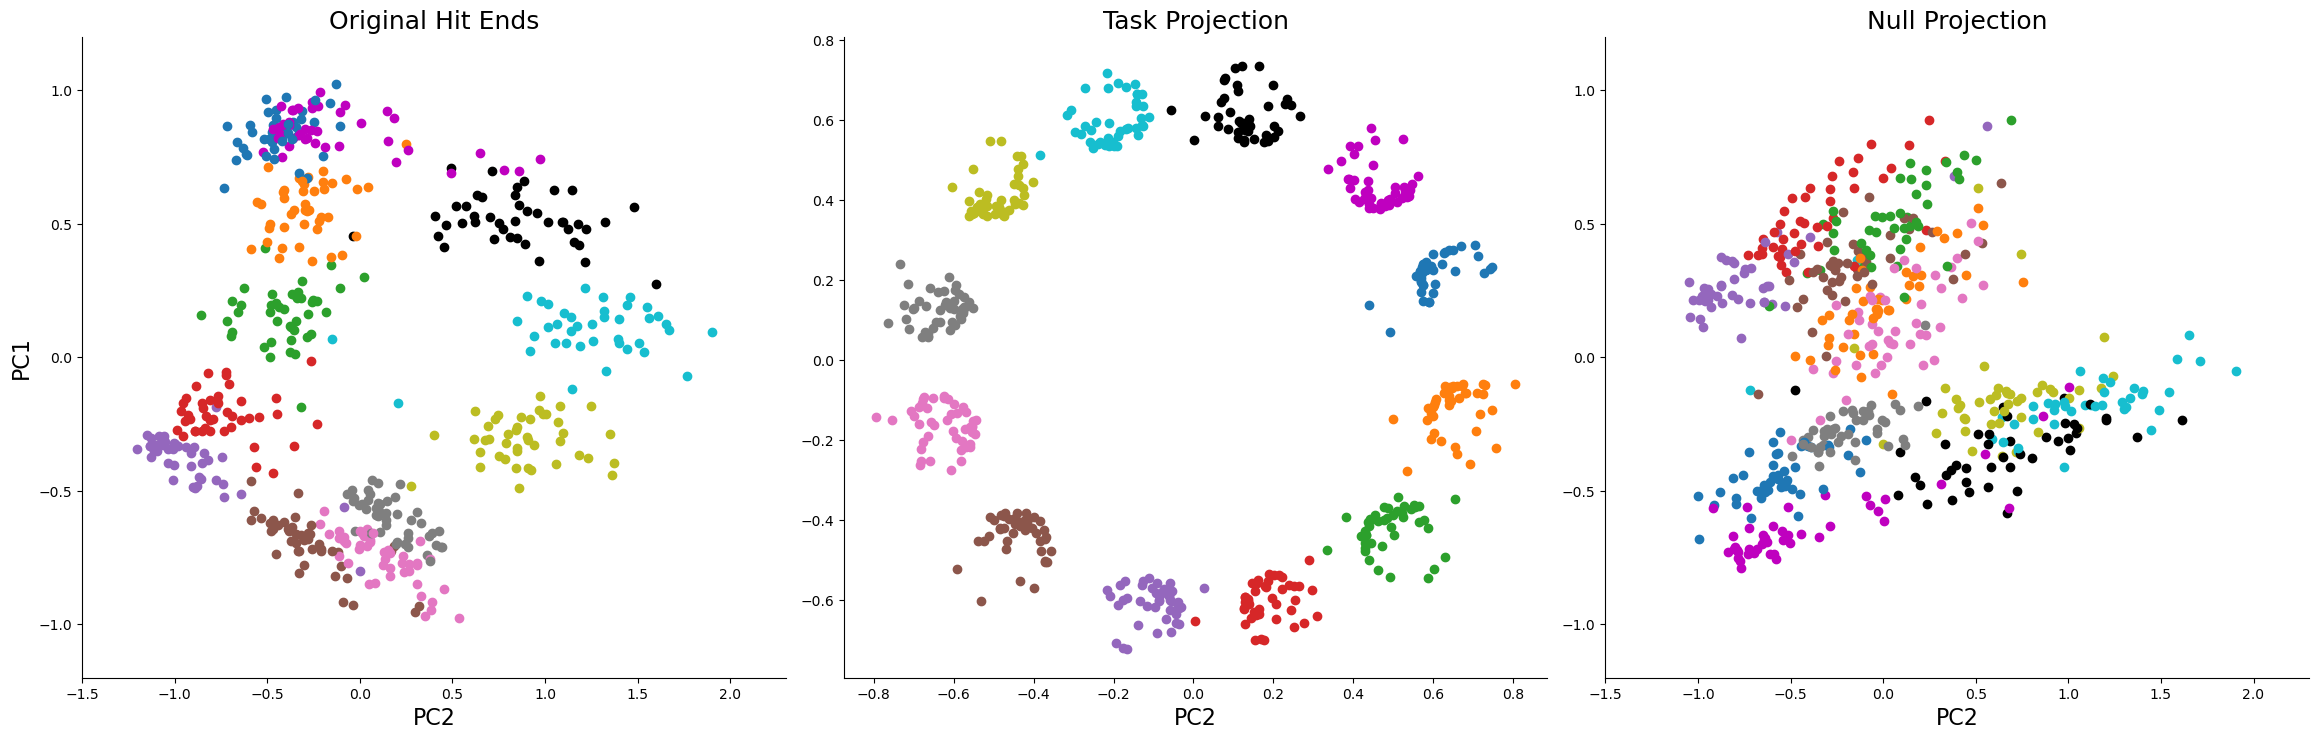

In [67]:
def reconstruct_samples(samples, num_components):
    return PCA(n_components=num_components).fit_transform(samples)

pca_reconstruction_fig, axes = plt.subplots(1,3,figsize=(23,7))
pca_reconstruction_fig.tight_layout()

x = reconstruct_samples(X,2)
for i, xx in enumerate(x):
    axes[0].plot(xx[0],xx[1],"o", color=colors[y_numbers[i]-1])
axes[0].set_ylabel("PC1")
axes[0].set_xlabel("PC2")
# axes[0].set_aspect("equal")
axes[0].set_ylim([-1.2,1.2])
axes[0].set_xlim([-1.5,2.3])
axes[0].set_title("Original Hit Ends",fontsize=18)

x = reconstruct_samples(X_task,2)
for i, xx in enumerate(x):
    axes[1].plot(xx[0],xx[1],"o", color=colors[y_numbers[i]-1])
# axes[1].set_ylabel("PC1")
axes[1].set_xlabel("PC2")
# axes[1].set_aspect("equal")
axes[1].set_title("Task Projection",fontsize=18)

x = reconstruct_samples(X_null,2)
for i, xx in enumerate(x):
    axes[2].plot(xx[0],xx[1],"o", color=colors[y_numbers[i]-1])
# axes[2].set_ylabel("PC1")
axes[2].set_xlabel("PC2")
# axes[2].set_aspect("equal")
axes[2].set_ylim([-1.2,1.2])
axes[2].set_xlim([-1.5,2.3])
axes[2].set_title("Null Projection",fontsize=18)

In [68]:
plot.save_figure(pca_reconstruction_fig, "pca_2d_reconstructions", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/pca_2d_reconstructions.pdf


In [113]:
def train_classifier(samples,labels,random_state):
    X_train, X_test, y_train, y_test = train_test_split(samples,labels,test_size=0.25,random_state=random_state)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.set_params(weights="distance").fit(X_train, y_train)
    true_classes = true_classes_to_one_hot(y_test.reshape(-1,1),n_classes=12)
    probs = probs_array(clf, true_classes, X_test)
    return clf.score(X_test, y_test), brier_multi(true_classes, probs)

n_repeats = 3
random_states = np.arange(1,n_repeats)

subject_scores = []
subject_scores_i = []
for subject_idx in range(46):
    subject_hit_ends = hit_ends[subject_idx]
    X, idxs = analysis.remove_nan_rows(subject_hit_ends.reshape(-1,64),return_idx=True)
    y_numbers = target_number_stack.reshape(-1)[idxs]
    decoder = subjects[subject_idx].decoder[-2:,:]
    task, null = analysis.compute_subspaces(decoder)
    X_null = (null @ X.T).T

    pca = PCA().fit(X_null)
    reconstructed_scores = []
    reconstructed_scores_i = []
    for num_components in range(1,63):
        projection = pca.components_[:num_components]
        reconstructed_samples = X_null @ projection.T

        projection = pca.components_[-num_components:]   
        reconstructed_samples_i = X_null @ projection.T

        scores = []
        scores_i = []
        for rs in random_states:
            score, _ = train_classifier(reconstructed_samples,y_numbers,rs)
            scores.append(score)

            score_i, _ = train_classifier(reconstructed_samples_i,y_numbers,rs)
            scores_i.append(score_i)

        reconstructed_scores.append(np.mean(scores))
        reconstructed_scores_i.append(np.mean(scores_i))
    subject_scores.append(reconstructed_scores)
    subject_scores_i.append(reconstructed_scores_i)

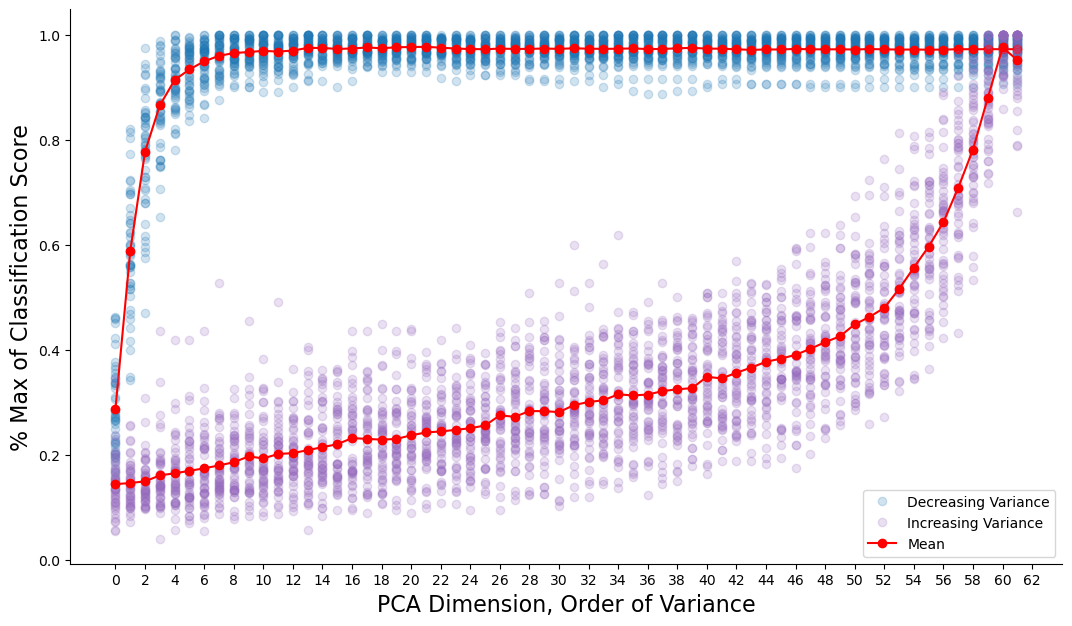

In [114]:
pca_score_fig, ax = plt.subplots()

percentages_up = np.array(subject_scores) / np.max(subject_scores,axis=1).reshape(-1,1)
for d in percentages_up:
    h1, = ax.plot(range(62),d,"o",color="tab:blue",alpha=0.2)
ax.plot(range(62),percentages_up.mean(axis=0),"r",linestyle="-",marker="o")
_ = ax.set_xticks(range(0,63,2),list(range(0,63,2)))

ax.set_ylabel("% Max of Classification Score")
ax.set_xlabel("PCA Dimension, Order of Variance")

percentages_down = np.array(subject_scores_i) / np.max(subject_scores_i,axis=1).reshape(-1,1)
for d in percentages_down:
    h2, = ax.plot(range(62),d,"o",color="tab:purple",alpha=0.2)
h3, = ax.plot(range(62),percentages_down.mean(axis=0),"r-",marker="o")

ax.legend(handles=[h1,h2,h3],labels=["Decreasing Variance", "Increasing Variance", "Mean"])

In [115]:
plot.save_figure(pca_score_fig, "pca_scores", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/pca_scores.pdf


In [ ]:
# good notes on explained variance
# https://ro-che.info/articles/2017-12-11-pca-explained-variance